# Credit Scoring Classification Project

Цель проекта — построить модель машинного обучения, которая по финансовым данным клиента
классифицирует его кредитный рейтинг как **Good**, **Standard** или **Poor**.

Датасет содержит 100 000 записей с 28 признаками: возраст, доход, история платежей, кредиты и т.д.

ссылка на Kaggle:https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data


Импорт библиотек

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Загрузка данных

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ml corse/dataframes/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ml corse/dataframes/test.csv')
train.head()

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Предобработка данных. Замена некорректных значений и типов

In [68]:
train['Age'] = pd.to_numeric(train['Age'], errors='coerce')
train.loc[train['Age'] < 0, 'Age'] = np.nan  # убираем отрицательные значения

Заполнение пропусков

In [69]:

force_numeric = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Loan',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
    'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Age_months'
]


for col in force_numeric:
    if col in train.columns:
        train[col] = pd.to_numeric(train[col], errors='coerce')
    if col in test.columns:
        test[col] = pd.to_numeric(test[col], errors='coerce')

num_cols = train.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols:
    if col == 'Credit_Score':
        continue
    med = train[col].median()
    train[col] = train[col].fillna(med)
    if col in test.columns:
        test[col] = test[col].fillna(med)

cat_cols = train.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'Credit_Score']

for col in cat_cols:
    train[col] = train[col].fillna('Unknown')
    if col in test.columns:
        test[col] = test[col].fillna('Unknown')

Преобразуем Credit_History_Age в месяцы

In [70]:
def to_months(x):
    try:
        parts = x.split()
        years = int(parts[0])
        months = int(parts[3])
        return years * 12 + months
    except:
        return np.nan

train['Credit_History_Age_months'] = train['Credit_History_Age'].apply(to_months)
train['Credit_History_Age_months'] = train['Credit_History_Age_months'].fillna(train['Credit_History_Age_months'].median())


Разделение данных

In [71]:
X = train.drop(columns=['Credit_Score', 'ID', 'Customer_ID', 'Name', 'SSN', 'Month'])
y = train['Credit_Score']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


Преобразование признаков

In [72]:
num_features = X.select_dtypes(include=[np.number]).columns
cat_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


Обучение и сравнение моделей

In [73]:
# Logistic Regression
pipe_logreg = Pipeline([('preprocess', preprocessor),
                        ('model', LogisticRegression(max_iter=1000, random_state=42))])
pipe_logreg.fit(X_train, y_train)
preds_logreg = pipe_logreg.predict(X_valid)

print(f"LogReg Accuracy: {accuracy_score(y_valid, preds_logreg):.4f}\n")
try:
    target_names = encoder.classes_
except NameError:
    target_names = None
print(classification_report(y_valid, preds_logreg, target_names=target_names))



LogReg Accuracy: 0.7262

              precision    recall  f1-score   support

        Good       0.59      0.61      0.60      3566
        Poor       0.78      0.69      0.73      5799
    Standard       0.75      0.79      0.77     10635

    accuracy                           0.73     20000
   macro avg       0.71      0.69      0.70     20000
weighted avg       0.73      0.73      0.73     20000



In [74]:
# Random Forest
pipe_rf = Pipeline([('preprocess', preprocessor),
                    ('model', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
pipe_rf.fit(X_train, y_train)
preds_rf = pipe_rf.predict(X_valid)

print(f"RandomForest Accuracy: {accuracy_score(y_valid, preds_rf):.4f}\n")
try:
    target_names = encoder.classes_
except NameError:
    target_names = None
print(classification_report(y_valid, preds_rf, target_names=target_names))


RandomForest Accuracy: 0.7790

              precision    recall  f1-score   support

        Good       0.72      0.71      0.72      3566
        Poor       0.78      0.77      0.77      5799
    Standard       0.80      0.81      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.77      0.76      0.76     20000
weighted avg       0.78      0.78      0.78     20000



In [75]:
# XGBoost
pipe_xgb = Pipeline([('preprocess', preprocessor),
                     ('model', XGBClassifier(n_estimators=200, random_state=42,
                                             eval_metric='mlogloss', n_jobs=-1))])
pipe_xgb.fit(X_train, y_train)
preds_xgb = pipe_xgb.predict(X_valid)

print(f"XGBoost Accuracy: {accuracy_score(y_valid, preds_xgb):.4f}\n")
try:
    target_names = encoder.classes_
except NameError:
    target_names = None
print(classification_report(y_valid, preds_xgb, target_names=target_names))

XGBoost Accuracy: 0.7336

              precision    recall  f1-score   support

        Good       0.63      0.69      0.66      3566
        Poor       0.76      0.68      0.72      5799
    Standard       0.76      0.78      0.77     10635

    accuracy                           0.73     20000
   macro avg       0.72      0.72      0.71     20000
weighted avg       0.74      0.73      0.73     20000



Важность признаков

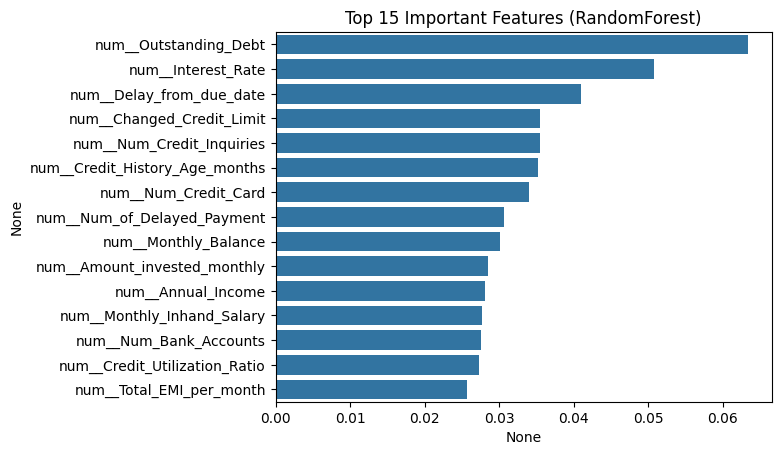

In [76]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
pipe_rf = Pipeline(steps=[('preprocess', preprocessor), ('model', rf)])
pipe_rf.fit(X_train, y_train)

importances = pipe_rf.named_steps['model'].feature_importances_
feature_names = pipe_rf.named_steps['preprocess'].get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 15 Important Features (RandomForest)")
plt.show()


## Выводы

- Лучший результат показал **RandomForest** с точностью 0.77.
- Основные факторы, влияющие на кредитный рейтинг:
  - уровень задолженности (Outstanding_Debt)
  - количество просрочек (Num_of_Delayed_Payment)
  - кредитная история (Credit_History_Age)
  - месячный доход и поведение платежей.
- Модель можно улучшить подбором гиперпараметров и балансировкой классов.
